In [456]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import pdb
import glob
import salem
from utils import constants as cnst
from wavelet import util, wav
from scipy.ndimage.measurements import label
from scipy import ndimage
from utils import u_arrays as ua, u_grid
from wavelet import util
import numpy.ma as ma
import pickle as pkl
from eod import mfg
from utils import u_grid, u_interpolate as u_int
from kpywavelet import wavelet as wvt
from utils import u_plot as uplot

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [2]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [649]:
data = xr.open_dataarray('/home/ck/DIR/cornkle/data/VERA/lsta_trend_chris/mean_lst_trend.nc')

In [650]:
data = data.sel(lat=slice(4,11), lon=slice(-15,10))

(array([6.0000e+00, 4.0000e+00, 1.9000e+01, 6.5800e+02, 5.6810e+03,
        2.0289e+04, 2.1107e+04, 4.6460e+03, 4.3800e+02, 4.0000e+01]),
 array([-0.41766205, -0.34274298, -0.2678239 , -0.19290482, -0.11798573,
        -0.04306665,  0.03185243,  0.10677151,  0.18169059,  0.25660968,
         0.33152875], dtype=float32),
 <a list of 10 Patch objects>)

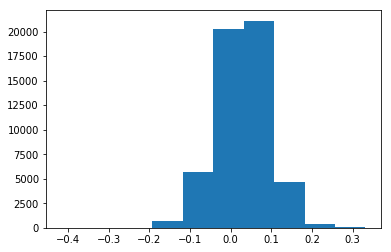

In [651]:
plt.hist(data.values.flat[data.values.flat>-999])

In [652]:
mask = data.values > -998

In [653]:
mask.shape

(140, 499)

In [654]:
data.values[data.values<=-998]=0.01

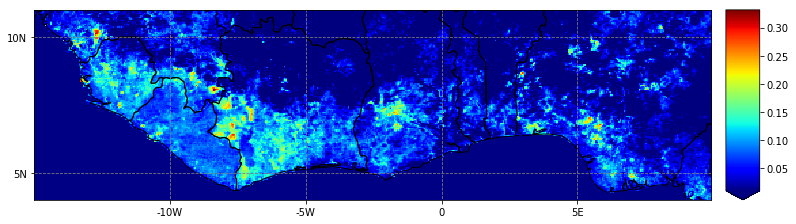

In [655]:
plt.figure(figsize=(13,9))
data.salem.quick_map(cmap='jet', vmin=0.01)

In [563]:
data.shape

(140, 499)

In [627]:
dic = util.waveletT1D(data.values, dataset='LSTATREND5K', mask=mask)
scale_ind =1

/home/ck/pythonWorkspace/proj_CEH/wavelet/oned.py:214: ComplexWarning: Casting complex values to real discards the imaginary part
  out[:, row, :] = coeffs
/home/ck/pythonWorkspace/proj_CEH/wavelet/oned.py:219: ComplexWarning: Casting complex values to real discards the imaginary part
  out[:, :, column] = coeffs


(0, 0.32)

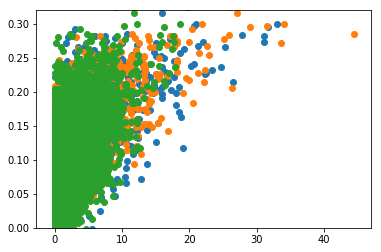

In [628]:
plt.scatter(dic['powerx'][5,:,:], data)
plt.scatter(dic['powerx'][2,:,:], data)
plt.scatter(dic['powerx'][7,:,:], data)
plt.ylim(0,0.32)

In [629]:
np.percentile(dic['powery'],99.7)

7.5926947325961365

In [630]:
def filters(power, sig):
    out = power.copy()
    cnt = 0
    for p, s in zip(power,sig):
        part = out[cnt,:,:]

        mini = np.min(p[s.astype(np.bool)])
        part[part<mini] = 0
        out[cnt,:,:] = part
        cnt += 1
        return out

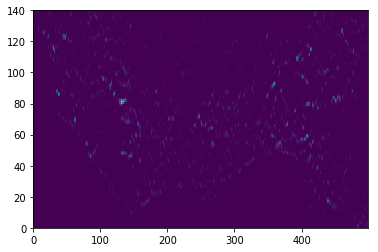

In [631]:
plt.pcolormesh(dic['powery'][scale_ind,:,:])

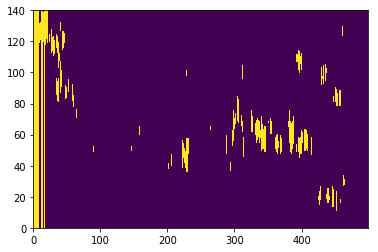

In [632]:
plt.pcolormesh(dic['sigy'][7,:,:])

In [633]:
np.min((dic['powery'][scale_ind,:,:])[(dic['sigy'][scale_ind,:,:]).astype(np.bool)])

7.102336153146066e-22

In [634]:
np.min((dic['powery'][scale_ind,:,:]))

6.416187804848371e-22

In [635]:
dic['scales']

array([ 16.        ,  21.11212657,  27.85761803,  36.75834736,
        48.50293013,  64.        ,  84.44850629, 111.4304721 ,
       147.03338944, 194.01172051, 256.        ])

In [636]:
sigy = filters(dic['powery'], dic['sigy'])

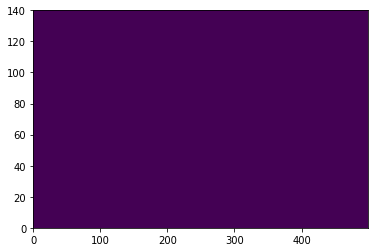

In [637]:
plt.pcolormesh(dic['powery'][scale_ind,:,:]-sigy[scale_ind,:,:])

Text(0.5, 1.0, 'Scale: 21.112126572366307')

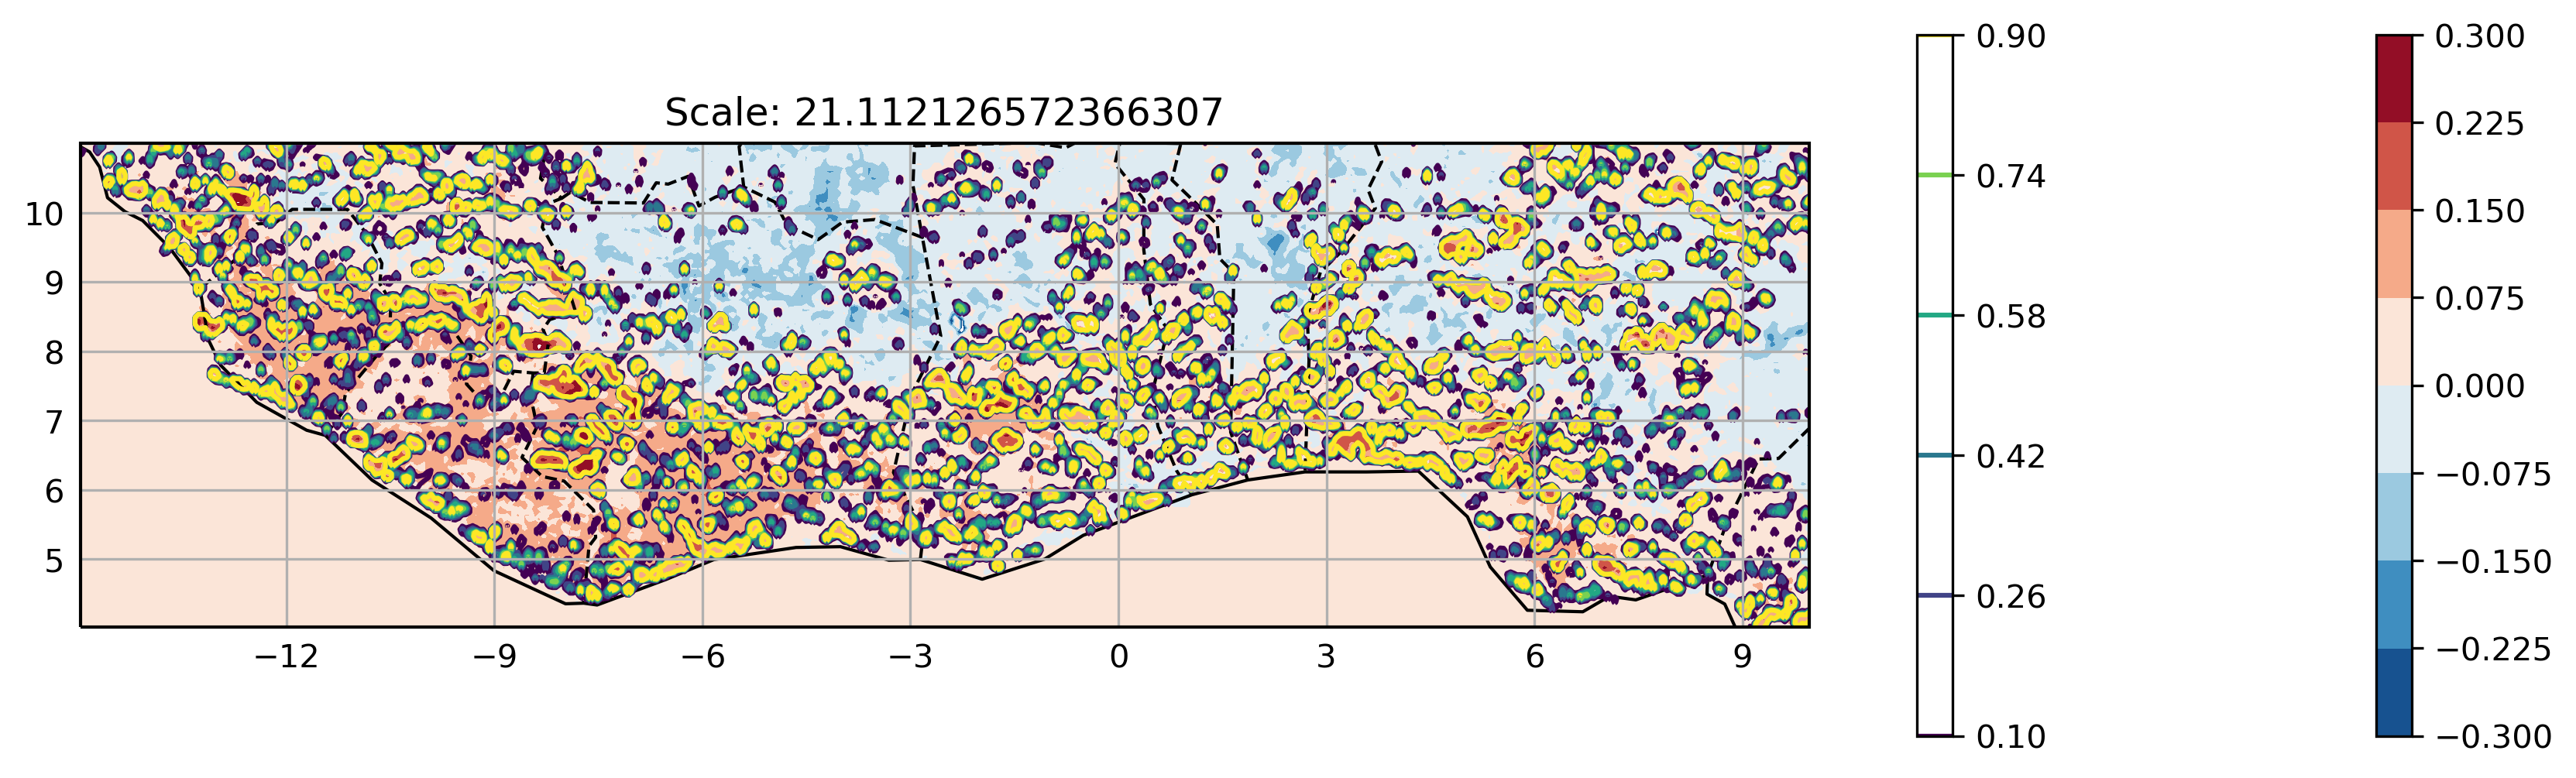

In [638]:

f = plt.figure(figsize=(15,4), dpi=300)
#plt.autoscale(False)
ax = f.add_subplot(111, projection=ccrs.PlateCarree()) # this opens a new plot axis
mapp = ax.contourf(data.lon, data.lat,data.values,levels=np.linspace(-0.3,0.3,9), cmap='RdBu_r', transform=ccrs.PlateCarree())  # this is the actual plot
#plt.colorbar(mapp)


maps = ax.contour(data.lon, data.lat,dic['powery'][scale_ind,:,:], levels=np.linspace(0.1,0.9,6))
# plt.contourf(data.lon, data.lat, dic['sigy'][scale_ind,:,:], colors='none', hatches='.',
#                      levels=[0.5, 1], linewidth=0.1)
ax.coastlines()   ## adds coastlines
# Gridlines
xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
xl.xlabels_top = False   ## labels off
xl.ylabels_right = False
#plt.title(title)
# Countries
ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
cbar = plt.colorbar(mapp)  # adds colorbar
cbar = plt.colorbar(maps)  # adds colorbar
plt.title('Scale: '+str(dic['scales'][scale_ind]))
# plt.ylim(data.lat.min(),data.lat.max())
# plt.xlim(data.lon.min(),data.lon.max())


[17 18 18 18 18 18 19 19 19 19 19 20 20 20 20 20 20 20 21 21 21 21 21 22
 22 22 22 22 23]


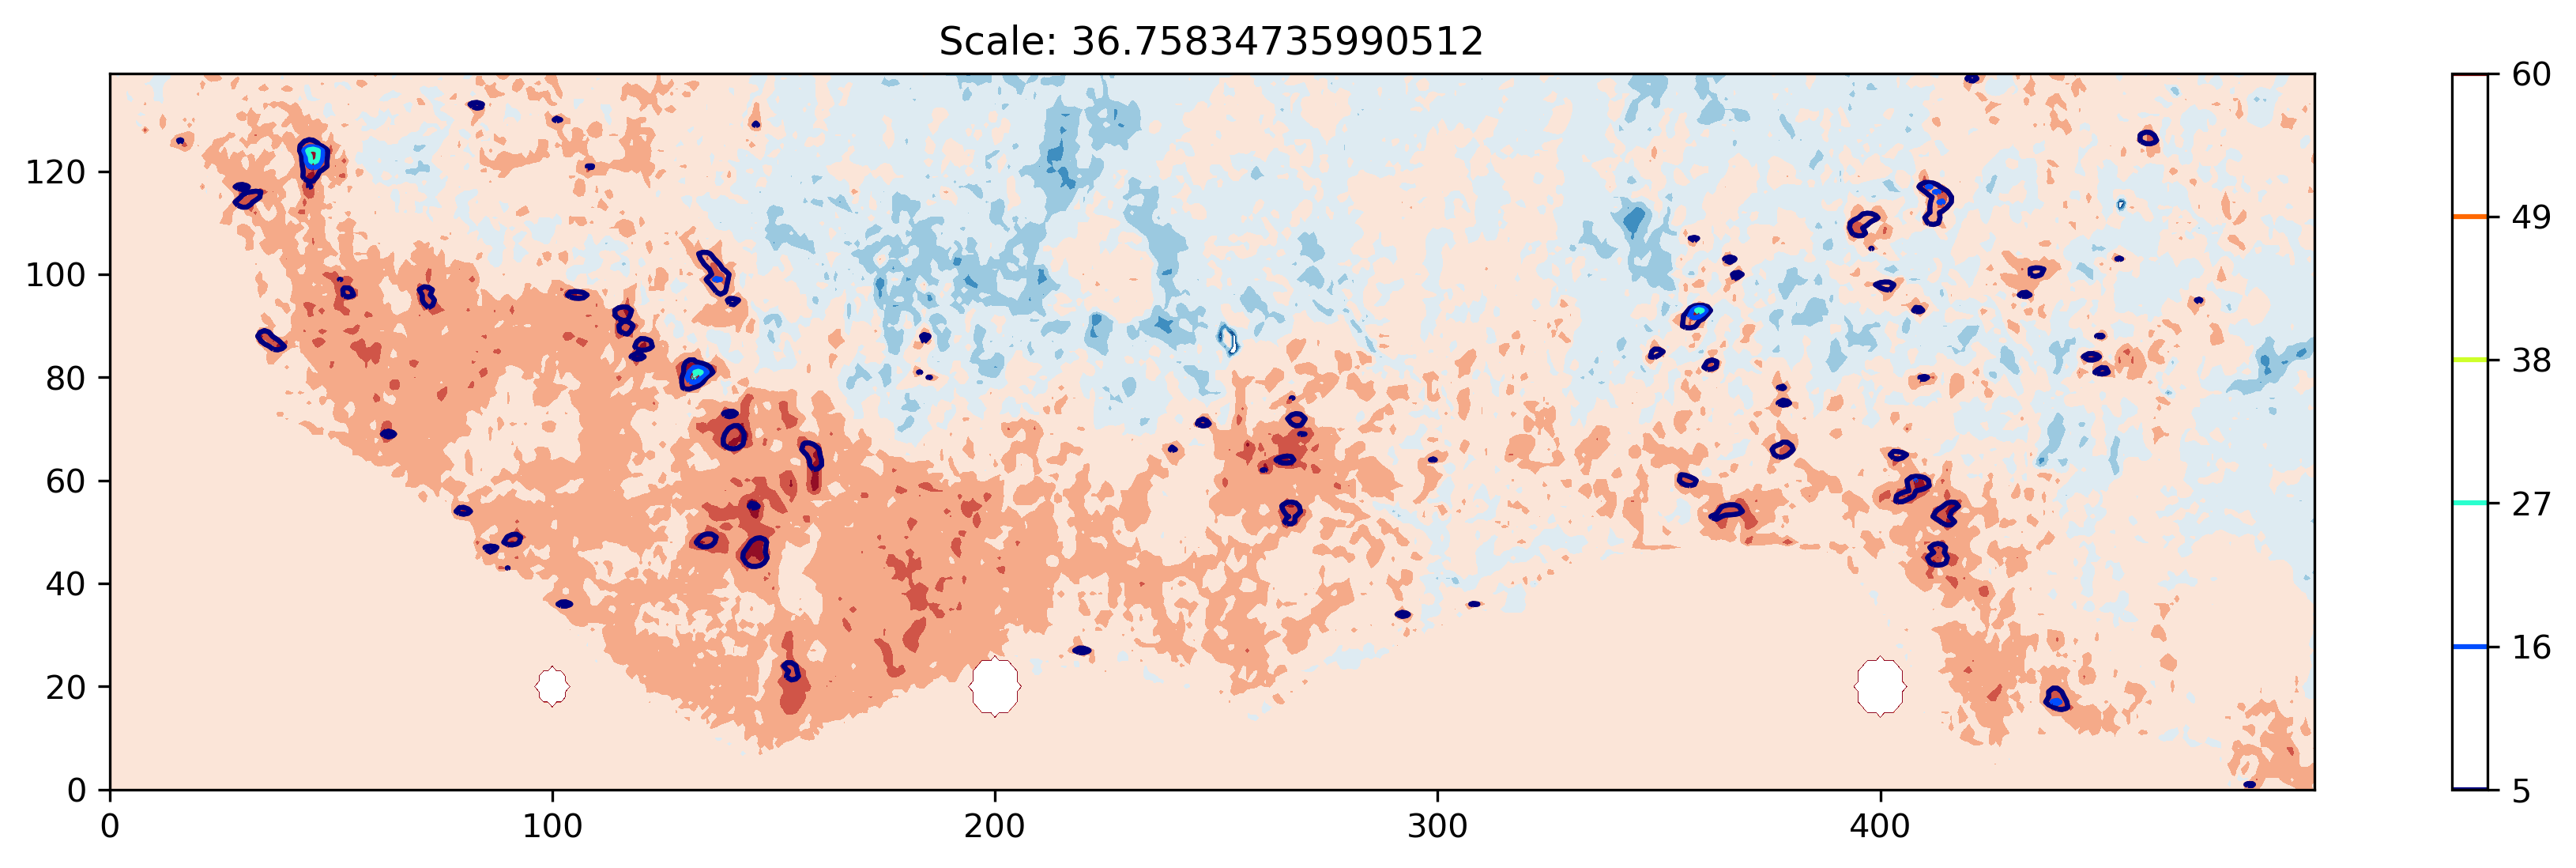

In [646]:
scale_ind = 3
iscale = (np.floor(dic['scales'][scale_ind] / 2. / 5.55)).astype(int)

ycircf, xcircf = ua.draw_cut_circle(100, 20, iscale, data.values)
print(ycircf)
data.values[ycircf,xcircf] = 50
f = plt.figure(figsize=(15,4), dpi=300)
ax = f.add_subplot(111)
mapp = ax.contourf(data.values,levels=np.linspace(-0.3,0.3,9), cmap='RdBu_r')
mapp = ax.contour(dic['powerx'][scale_ind,:,:], levels=np.linspace(5,60,6))
mapp = ax.contour(dic['powerx'][scale_ind,:,:], levels=np.linspace(5,60,6), cmap='jet')
#mapp = ax.contour(dic['powery'][4,:,:], levels=np.linspace(7,60,6), cmap='Greens')
plt.title('Scale: '+str(dic['scales'][scale_ind]))


plt.colorbar(mapp)

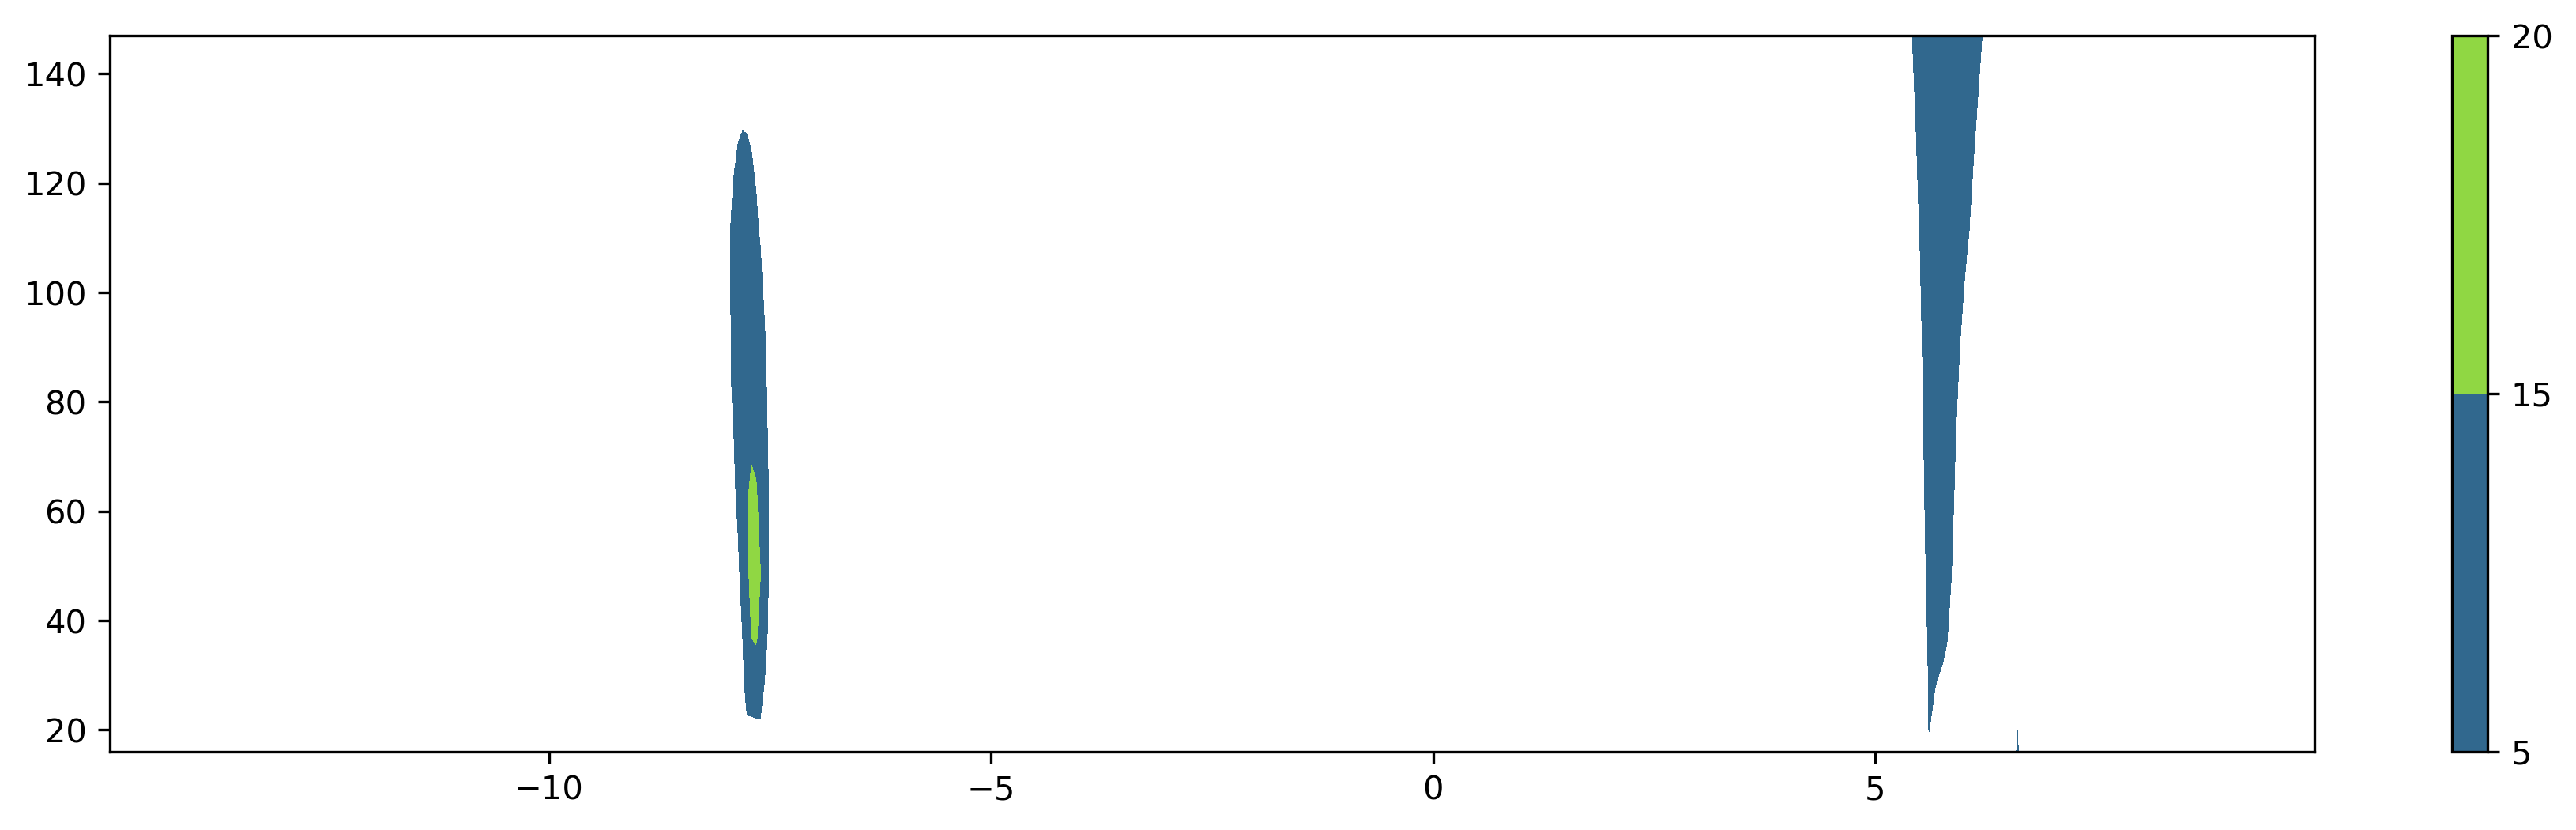

In [640]:
scale_ind = 2
f = plt.figure(figsize=(15,4), dpi=300)
ax = f.add_subplot(111)
mapp = ax.contourf(data.lon, dic['scales'][0:9],  dic['powerx'][0:9,45,:],levels=[5,15,20])
plt.colorbar(mapp)

In [641]:
maxperpix = dic['powery'].argmax(axis=0)

dom_scale = np.zeros_like(data)
power_scale = np.zeros_like(data)
scales = dic['scales']
for i in range(maxperpix.shape[0]):
    for j in range(maxperpix.shape[1]):
        max = maxperpix[i,j]

        power = dic['powery'][:,i,j]
        scal = scales[max]
        power_max = power[max]
        
        if power_max < 5:
            power_max = -999
            scal = -999
        power_scale[i,j] = power_max
        dom_scale[i,j] = scal



In [642]:
dic['scales']

array([ 16.        ,  21.11212657,  27.85761803,  36.75834736,
        48.50293013,  64.        ,  84.44850629, 111.4304721 ,
       147.03338944, 194.01172051, 256.        ])

Text(0.5, 1.0, 'Scale: 64.0')

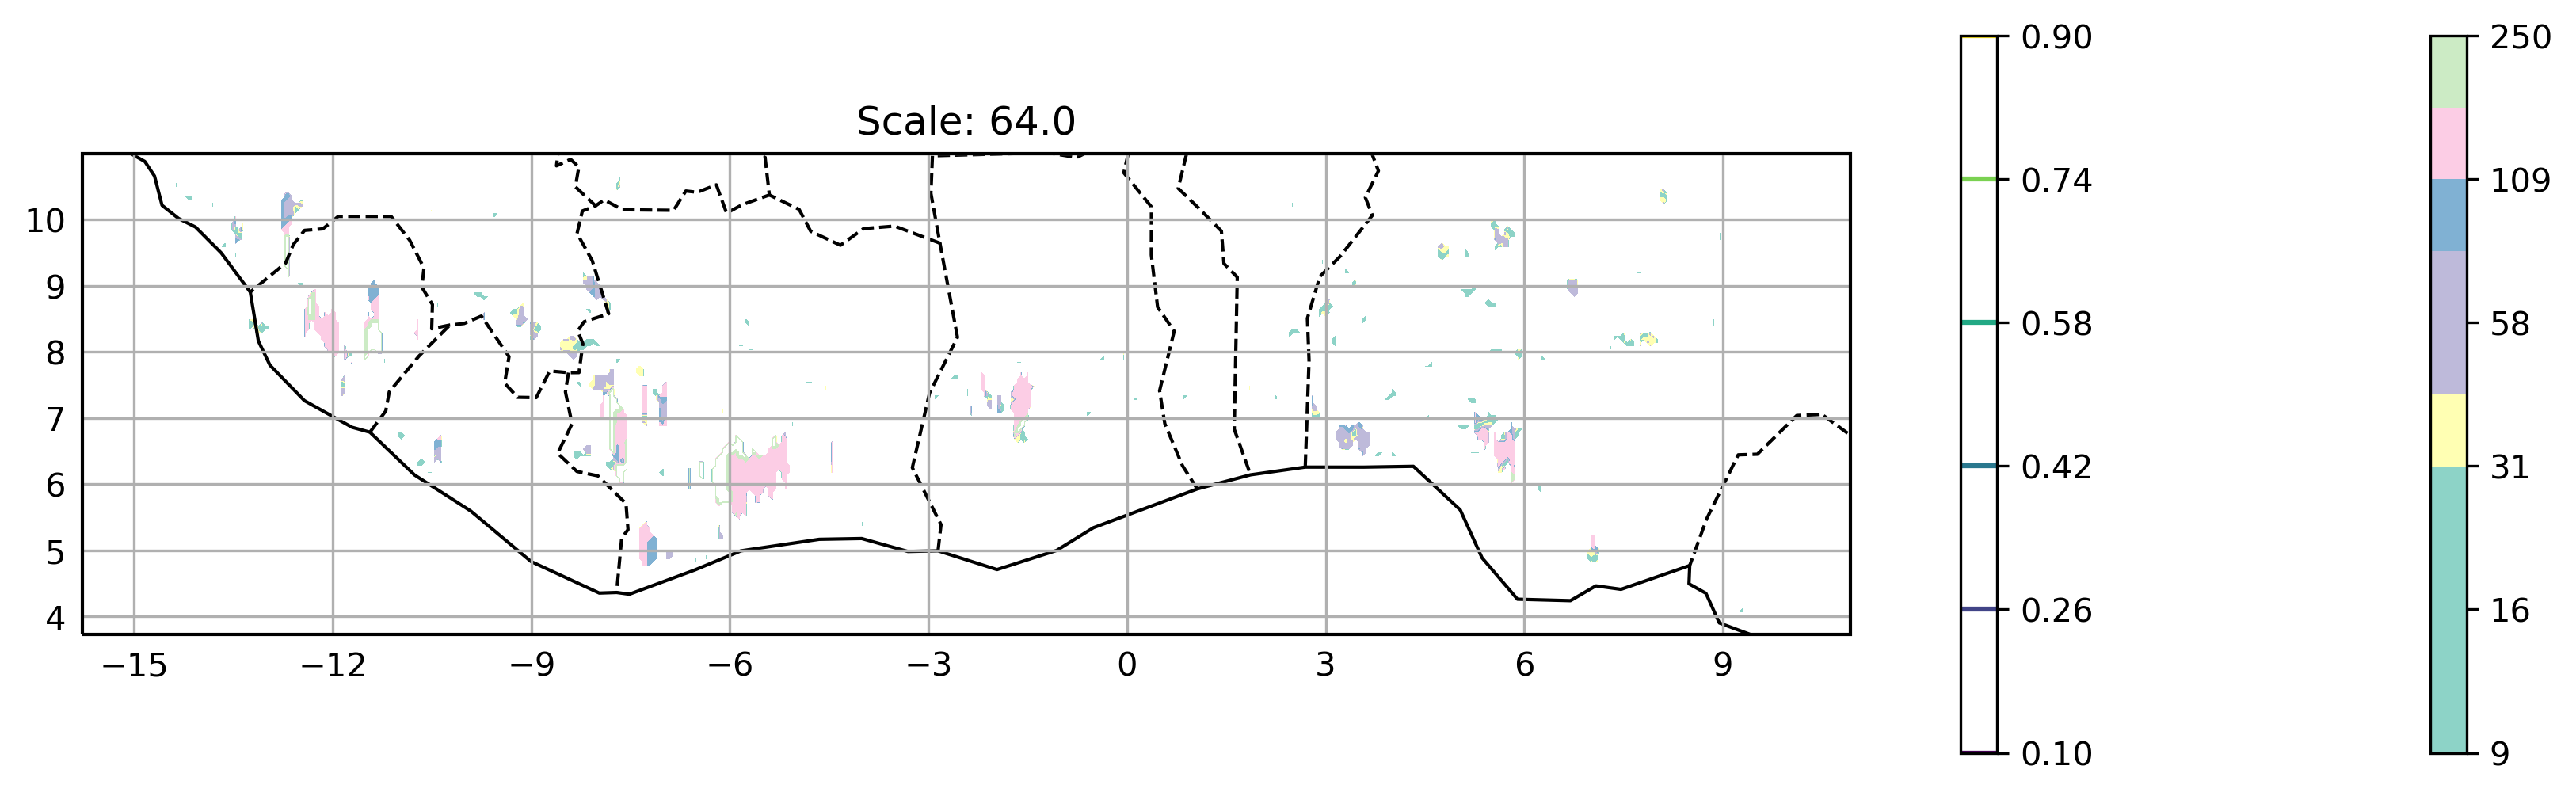

In [643]:
scale_ind = 5
f = plt.figure(figsize=(15,4), dpi=300)
ax = f.add_subplot(111, projection=ccrs.PlateCarree()) # this opens a new plot axis
cmapp = uplot.discrete_cmap(5, base_cmap='Blues')
#mapp = ax.contour(ttrend.month, era_trend.latitude, tmean.transpose()-273.15, 
#                  cmap='Reds', extend='both', levels=np.linspace(20,35,4), linestyles='dotted')  # this is the actual plot
#plt.clabel(mapp, inline=1, fontsize=10, fmt="%1.1f")


# mappable = ax3.pcolormesh(np.arange(0.5,13,1), np.arange(0,26,1),da.sel(lat=slice(0,25)).values
#                           ,cmap=cmapp, vmin=0.05, vmax=0.80)

# mappable = ax.pcolormesh(np.arange(0.5,13,1), ccover_trend.lat,ctrend.transpose()
#                           ,cmap=cmapp, vmin=0.1, vmax=1)

#cbar = plt.colorbar(mappable, ticks=np.linspace(0.1,1,6))
mapp = ax.contourf(data.lon, data.lat,dom_scale, levels=[9,12,16,22,31,42,58,79,109,200,250], cmap='Set3', transform=ccrs.PlateCarree())  # this is the actual plot
#plt.colorbar(mapp)
#ax.contour(data.lon, data.lat,power_scale, levels=np.linspace(5,30,6))

ax.coastlines()   ## adds coastlines
# Gridlines
xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
xl.xlabels_top = False   ## labels off
xl.ylabels_right = False
#plt.title(title)
# Countries
ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
cbar = plt.colorbar(mapp)  # adds colorbar
cbar = plt.colorbar(maps)  # adds colorbar
plt.title('Scale: '+str(dic['scales'][scale_ind]))

In [656]:
powery = dic['powery']
powerx = dic['powerx']
powery[powery<5]=0
powerx[powerx<5]=0

In [657]:
ds = xr.Dataset()
ylist = xr.DataArray(powery, coords={'scales' : dic['scales'], 'lat': data.lat, 'lon': data.lon},
                                dims=['scales', 'lat', 'lon'])  # [np.newaxis, :])
xlist = xr.DataArray(powerx, coords={'scales' : dic['scales'], 'lat': data.lat, 'lon': data.lon},
                               dims=['scales', 'lat', 'lon'])

dlist = xr.DataArray(data.values, coords={'lat': data.lat, 'lon': data.lon},
                               dims=[ 'lat', 'lon'])

ds['power_y'] = ylist
ds['power_x'] = xlist
ds['trend'] = dlist

In [658]:
ds

<xarray.Dataset>
Dimensions:  (lat: 140, lon: 499, scales: 11)
Coordinates:
  * lon      (lon) float64 -14.97 -14.92 -14.87 -14.82 ... 9.862 9.912 9.962
  * lat      (lat) float64 4.025 4.075 4.125 4.175 ... 10.85 10.9 10.95 11.0
  * scales   (scales) float64 16.0 21.11 27.86 36.76 ... 111.4 147.0 194.0 256.0
Data variables:
    power_y  (scales, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    power_x  (scales, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    trend    (lat, lon) float32 0.01 0.01 0.01 ... 0.039562136 0.027301313

In [659]:
ds.to_netcdf('/home/ck/DIR/cornkle/data/VERA/lsta_trend_chris/LSTtrend_scales_cutoff5.nc')